In [32]:
%load_ext autoreload
%autoreload 2
print('\n')
print('=============loading external modules now=========')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.enable_eager_execution()
# print(f'tensorflow version: {tf.__version__}')
from tensorflow.keras import layers
import os, glob, math, random, time, datetime, PIL, imageio
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from IPython import display
import xml.etree.ElementTree as ET 
# print('\n')
# print('=============loading user-defined modules now=========')
# print('\n')
start_=time.time()
start=time.time()
from optimizers import *
# print(f'\t\toptimizers took {time.time()-start} s in loading')
# print('======================')
# print('\n')
start=time.time()
from losses import *
# print(f'\t\tlosses took {time.time()-start} s in loading')
# print('======================')
# print('\n')
start=time.time()
from g_model import *
# print(f'\t\tgenerator model took {time.time()-start} s in loading')
# print('======================')
# print('\n')
start=time.time()
from d_model import *
# print(f'\t\tdiscriminator model took {time.time()-start} s in loading')
# print('======================')
# print('\n')
start=time.time()
from static import *
# print(f'\t\tstatic took {time.time()-start} s in loading')
# print('======================')
# print('\n')
start=time.time()
from onboarding import *
# print(f'\t\tonboarding took {time.time()-start} s in loading')
# print('======================')
# print('\n')
start=time.time()
from generate_and_save_images import *
# print(f'\t\tgenerate_and_save_images took {time.time()-start} s in loading')
print('======================')
from train_step import *
# print(f'\tall user-defined modules took {time.time()-start_} s in loading')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


=============loading external modules now=========


In [33]:
tf.__version__

'2.3.0'

In [34]:
import keras
from keras.callbacks import TensorBoard

In [35]:
images_inputs, normalized_image_vectors, breeds_names = onboarding(all_images, all_breeds)

In [48]:
BUFFER_SIZE = 20000
BATCH_SIZE = 16
# imagesIn = tf.cast(normalized_image_vectors, 'float32')
ds = tf.data.Dataset.from_tensor_slices((normalized_image_vectors,)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)

<BatchDataset shapes: ((None, 64, 64, 3),), types: (tf.float64,)>


In [42]:
from tensorflow.python.framework import ops
ops.convert_to_tensor()

ValueError: Attempt to convert a value (<BatchDataset shapes: (None, 64, 64, 3), types: tf.float64>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>) to a Tensor.

# Generative Network

The purpose of a generative network is to use a deconvolution network and generate a random image from a random vector.
Reference: https://arxiv.org/pdf/1505.04366.pdf

(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 64, 64, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
CPU times: user 274 ms, sys: 56.1 ms, total: 331 ms
Wall time: 324 ms


<tf.Tensor: shape=(), dtype=float32, numpy=0.69330424>

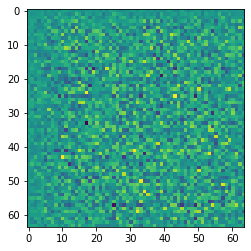

In [50]:
%%time
generator = g_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(type(generated_image))
plt.imshow((generated_image[0, :, :, 0]))
generator.predict(noise, steps=10).shape
generator_loss(generator.predict(noise, steps=10))

In [51]:
discriminator = d_model()
decision = discriminator(generated_image)
print(decision)
discriminator

(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 256)
(None, 1)
tf.Tensor([[0.6072805]], shape=(1, 1), dtype=float32)


In [10]:
discriminator, generator

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f3d08712790>,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f3e21ac4dd0>)

In [30]:
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

In [37]:
log_path = './logs'
callback = TensorBoard(log_path)

In [6]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
checkpoint_prefix = os.path.join('./training-checkpoints-6', "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float64>


In [21]:
type(imagesIn), type(ds)

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.data.ops.dataset_ops.BatchDataset)

# Training Loop

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    G_loss_list, D_loss_list = [], []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
          generated_images = generator(noise, training=True)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)
            
    print(gen_loss, disc_loss)
    
#           G_loss_list.append(gen_loss.numpy())
#           D_loss_list.append(disc_loss.numpy())
    
#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [31]:
g,d = train_step(imagesIn[:3,:, :, :])

tf.Tensor(0.4614398, shape=(), dtype=float32) tf.Tensor(1.5517988, shape=(), dtype=float32)


In [52]:
discriminator(ds)

ValueError: Attempt to convert a value (<BatchDataset shapes: ((None, 64, 64, 3),), types: (tf.float64,)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>) to a Tensor.

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    if (epoch % 10 == 0):
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('../training_results_6/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
%%time
tf.enable_eager_execution()
print('Starting training')
train_dataset=ds
EPOCHS = 12
train(train_dataset, EPOCHS)

ValueError: tf.enable_eager_execution must be called at program startup.

In [53]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32768)             3276800   
_________________________________________________________________
batch_normalization_7 (Batch (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 256)      

In [17]:
checkpoint_dir='training_checkpoints'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5700045cd0> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5700063790>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5700045390> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5700045cd0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f577995d350> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f5700136c10>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f577995d7d0> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f577995d350>).

Two checkpoint references resolved to different objects (<tensorflow.python

In [74]:
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
for _ in range(10):
  discriminator_optimizer.minimize()  # Variables will be restored on creation.
status.assert_consumed()  # Optional sanity checks.
checkpoint.save(file_prefix=checkpoint_prefix)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7f6cd474bc50> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6cd474b090>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6cd474b090> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f6cd475df50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7f6cd46fa990> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f6cd4724890>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6cd4715b90> and <tensorflow.python.keras.layers.core.Dense object at 0x7f6cd4712950>).


TypeError: minimize() missing 2 required positional arguments: 'loss' and 'var_list'

In [23]:
import glob, imageio

anim_file = 'dcgan-2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('../iter2/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [257]:
pip show protobuf

Name: protobuf
Version: 3.13.0
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: None
Author-email: None
License: 3-Clause BSD License
Location: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages
Requires: six, setuptools
Required-by: tensorflow-serving-api, tensorflow-docs, sagemaker, protobuf3-to-dict, tensorflow-gpu, tensorboard
Note: you may need to restart the kernel to use updated packages.


In [258]:
pip install --upgrade protobuf

Requirement already up-to-date: protobuf in /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages (3.13.0)
Note: you may need to restart the kernel to use updated packages.


In [260]:
anim_file

'dcgan.gif'

In [39]:
pwd

'/home/ubuntu/oh-my-dog/src'

In [92]:
int(4.5)

4